In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network

from tf_agents.policies import policy_saver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
#from env.RideSimulator.Grid import Grid
import tf_agents


import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

Loading trip data...
Data loading complete


In [2]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper params

num_iterations = 40 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)


In [6]:
#catagorical dqn agent
gamma = 0.99
num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

In [7]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [8]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [9]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
hex count  114
Number of trips generated: 1946


In [10]:

#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [11]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

[[ 6.8         8.1         7.         19.98164646 24.58980093 40.        ]]
-18.83
[[ 9.9        24.1         8.         19.10479069 54.16633485 39.        ]]
13.199999999999989
[[ 2.7        27.3         8.         19.62896592 26.58602812 38.        ]]
72.0
[[ 8.          9.1         9.         20.88936462 26.39115424 37.        ]]
-23.570000000000007
[[ 6.9         2.9        11.         11.80707652 28.47845058 36.        ]]
-36.66000000000001
[[12.7        27.5        11.         28.96910029 19.46757677 35.        ]]
5.659999999999968
[[20.8        22.8        14.         36.33170602 41.90430738 34.        ]]
-64.12
[[21.5        24.1        15.         41.08446783 52.27237729 33.        ]]
-64.52000000000004
[[ 7.4         7.2        19.         28.98423972 49.31992856 32.        ]]
-25.820000000000007
[[ 6.8        30.2        20.          1.33674817 46.18771229 31.        ]]
54.099999999999994
[[10.          9.2        20.         14.50025111 38.18909862 30.        ]]
-36.6399999

[[ 7.8        52.6        15.         41.1522552   9.92509975 17.        ]]
121.32
[[ 8.         19.1        19.         47.66770868  0.1018572  16.        ]]
9.429999999999978
[[ 1.6         5.         20.         43.77120004  0.74523279 15.        ]]
5.780000000000001
driver reward  200.24999999999994
[[12.4   27.8    7.    13.221 26.405 40.   ]]
8.659999999999968
[[ 6.9        14.7         7.         21.00752256 23.75252877 39.        ]]
2.2799999999999727
[[13.7    6.9    9.    15.977 39.975 38.   ]]
-69.02000000000001
[[ 7.7        31.4         9.         41.31850285 32.93037003 37.        ]]
52.02999999999997
[[22.8        11.1        10.         48.55722958 23.76093989 36.        ]]
-116.13
[[19.7        39.6        22.         14.92219972  0.51541997 35.        ]]
-1.3100000000000023
[[12.9        23.          5.         25.43705661 18.20937096 34.        ]]
-10.530000000000001
[[17.         18.9         9.          7.65981527 49.28788944 33.        ]]
-51.53
[[ 2.1   23.1    9

[[ 8.6        37.6        20.         50.86369992 19.93932719  3.        ]]
66.45999999999998
[[ 5.8        33.1        13.         21.08995735 26.167399    2.        ]]
70.37
[[ 2.4        33.5        14.         50.91883391 35.55119727  1.        ]]
1594.47
[[ 9.6        13.8        21.         56.98529061 49.86057636  0.        ]]
-18.78
[[ 6.8        11.6         9.         52.04418669 58.90122797 -1.        ]]
-7.279999999999987
[[ 7.9   18.2   20.    52.456 40.416 -1.   ]]
7.1299999999999955
[[ 8.9    8.6   22.    46.299 45.341 -1.   ]]
-31.25
[[ 5.8        14.2         8.         36.96075187 45.36543467 -1.        ]]
8.0
[[11.    20.2   11.    14.964 34.215 -1.   ]]
-7.039999999999992
[[15.6        14.5        12.          4.77758288 59.77865542 -1.        ]]
-56.670000000000016
[[10.9         4.9        12.          4.58176774 53.66979874 -1.        ]]
-56.860000000000014
[[13.9        12.         12.          8.9550125  28.43484297 -1.        ]]
-53.53
[[12.1        14.       

[[ 7.6    4.6   19.    12.39  46.427 -1.   ]]
-35.739999999999995
[[ 4.90000000e+00  1.10000000e+01  1.90000000e+01  5.03247251e-02
   5.57860077e+01 -1.00000000e+00]]
3.469999999999999
[[11.3        27.6        19.         16.19368226 20.75238388 -1.        ]]
15.369999999999948
[[ 5.9        35.1        20.         37.17779809  0.30553338 -1.        ]]
76.30000000000001
[[18.6        17.1        14.         39.94256519 20.1698618  -1.        ]]
-68.19000000000003
driver reward  -286.18000000000075
[[ 8.7        17.7         9.         20.44052918 28.58218523 40.        ]]
0.12000000000000455
[[ 8.7        25.6         9.          1.32404697 15.44117267 39.        ]]
26.190000000000026
[[ 9.5    7.9   13.    13.279 16.49  38.   ]]
-37.58
[[ 8.1    5.6   13.    13.709 27.943 37.   ]]
-35.78999999999999
[[20.8        14.1        13.         17.15090332 34.90272798 36.        ]]
-92.82999999999998
[[15.9        16.8        13.         29.48999962 52.0857227  35.        ]]
-51.09000000000

[[ 8.3        14.          9.         48.65095358 34.65260175 -1.        ]]
-9.409999999999997
[[13.7        16.6        12.         47.10917269 29.3641814  -1.        ]]
-37.01000000000002
[[ 8.7        10.3        14.         29.32819259 29.75049156 -1.        ]]
-24.299999999999997
[[16.1   16.2   14.     5.382 49.927 -1.   ]]
-54.41
[[13.7   21.    14.     5.171 19.876 -1.   ]]
-22.490000000000038
[[12.7        30.         14.         23.78298609 54.4981817  -1.        ]]
13.909999999999968
[[17.5        18.3        15.         17.42407265 43.7564212  -1.        ]]
-56.859999999999985
[[13.6        23.1        15.         11.66681563 26.36218808 -1.        ]]
-14.890000000000015
[[ 6.9        14.6        16.         27.36758395 33.08982494 -1.        ]]
1.9499999999999886
[[ 6.4   27.7   16.     4.326 38.    -1.   ]]
48.52999999999997
[[12.9        22.4        16.          6.96860133 28.91523431 -1.        ]]
-12.509999999999991
[[ 9.5        29.5        16.         22.3757799  44.

[[ 8.4         6.6        19.         33.55343009 38.34219343 -1.        ]]
-34.5
[[12.9    2.    19.    24.517 28.295 -1.   ]]
-79.83
[[11.6    6.8   19.    16.777 32.928 -1.   ]]
-55.27999999999999
[[13.5        25.         19.         10.23847548 15.77224884 -1.        ]]
-7.949999999999989
[[14.8         6.7        20.          0.37589025 20.96520814 -1.        ]]
-77.05000000000001
[[ 3.4        12.9        20.          6.63738973  5.87969347 -1.        ]]
19.789999999999992
[[ 4.5   13.    22.    11.532 16.087 -1.   ]]
12.75
[[18.1        29.4        23.          2.31536807  8.63836364 -1.        ]]
-24.25
[[10.1   40.9    7.    20.037 56.456 -1.   ]]
67.30000000000001
[[ 2.6        25.9         8.         44.33291967 44.69777043 -1.        ]]
68.04999999999998
[[ 3.5        21.3        12.         26.60622176 42.40325693 -1.        ]]
46.84
[[ 8.4         5.8        13.         34.33812571 47.7588805  -1.        ]]
-37.14
[[10.3   18.6   13.    24.908 53.91  -1.   ]]
-7.63000000

[[ 5.1   19.7   21.    43.795 25.451 34.   ]]
30.840000000000003
[[ 6.1        21.          8.         40.52990348 45.22030895 33.        ]]
28.42999999999998
[[10.3    6.2   10.    25.688 47.447 32.   ]]
-48.55
[[ 9.          7.5        10.         21.91431968 47.21639459 31.        ]]
-35.55
[[ 3.2   15.8   10.     9.562 50.066 30.   ]]
30.700000000000003
[[ 8.9         7.4        10.         10.85103825 46.61799211 29.        ]]
-35.21000000000001
[[ 5.7        10.6        10.         15.34543306 43.49606286 28.        ]]
-3.210000000000008
[[ 4.2        36.7        11.         17.00019992  2.76140378 27.        ]]
92.96999999999997
[[17.2        13.5         7.         17.25329363 17.15683609 26.        ]]
-70.69
[[16.8    4.1    8.     6.917 33.277 25.   ]]
-99.03
[[15.          3.6         8.          6.98684533 44.79599433 24.        ]]
-88.62000000000002
[[ 6.         22.6         8.         27.58142758 35.84876469 23.        ]]
34.379999999999995
[[ 7.2    2.1   10.    18.738 

[[ 5.3        27.7         6.         16.97287393  5.34403259 20.        ]]
55.900000000000006
[[ 6.    19.8    7.     2.658 21.796 19.   ]]
25.139999999999986
[[14.1         8.5         7.          0.09526767 44.17738465 18.        ]]
-66.42000000000002
[[10.8        12.          8.         10.52514484 58.4197477  17.        ]]
-32.76000000000002
[[11.          2.5         8.          7.6518568  50.36161367 16.        ]]
-65.45
[[ 6.1    8.9    8.     4.435 54.967 15.   ]]
-11.5
[[16.         11.7         9.         14.32800756 48.71696512 14.        ]]
-68.59
[[ 7.7         9.8         9.         19.41093944 56.84207822 13.        ]]
-19.25
[[19.    30.5   10.    25.678 26.551 12.   ]]
-26.650000000000034
[[ 9.     2.9   11.    17.693 26.898 11.   ]]
-50.730000000000004
[[ 7.4        24.7        12.         10.59575262 52.87636418 10.        ]]
31.92999999999998
[[ 9.7        13.4        12.         23.70816033 33.85778165  9.        ]]
-20.77000000000001
[[29.5        13.         12

<ipython-input-11-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [30]:
#evaluate a trained policy with respect to a pre-generated static environment
pickup_distance_brackets = [0.75, 1.5, 2.5, 5, 7.5, 10]
trip_distance_brackets = [5, 10, 15, 25, 35, 50]
    
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i
    
#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
    pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
    pickup_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                pickup_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            pickup_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", pickup_trip_counts )
    for j in range(len(pickup_distance_brackets)+1):
        pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    print (pickup_accepted_trips)
    print(pickup_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

[[ 6.8         8.1         7.         19.98164646 24.58980093 40.        ]]
-18.83
[[ 9.9        24.1         8.         19.10479069 54.16633485 39.        ]]
13.199999999999989
[[ 2.7        27.3         8.         19.62896592 26.58602812 38.        ]]
72.0
[[ 8.          9.1         9.         20.88936462 26.39115424 37.        ]]
-23.570000000000007
[[ 6.9         2.9        11.         11.80707652 28.47845058 36.        ]]
-36.66000000000001
[[12.7        27.5        11.         28.96910029 19.46757677 35.        ]]
5.659999999999968
[[20.8        22.8        14.         36.33170602 41.90430738 34.        ]]
-64.12
[[21.5        24.1        15.         41.08446783 52.27237729 33.        ]]
-64.52000000000004
[[ 7.4         7.2        19.         28.98423972 49.31992856 32.        ]]
-25.820000000000007
[[ 6.8        30.2        20.          1.33674817 46.18771229 31.        ]]
54.099999999999994
[[10.          9.2        20.         14.50025111 38.18909862 30.        ]]
-36.6399999

[[ 8.         12.3        11.         17.17501027 16.43655041 -1.        ]]
-13.01000000000002
[[ 2.1        12.9        11.          6.34789184  6.12035921 -1.        ]]
28.5
[[ 1.1       17.1       12.         8.7495262 23.2248915 -1.       ]]
49.059999999999974
[[ 5.5         2.6        12.          2.56003648 19.05844689 -1.        ]]
-28.269999999999996
[[ 7.8         5.1        12.          5.33165291  8.78423543 -1.        ]]
-35.42999999999999
[[ 5.7        16.2        13.          9.61487685 27.68827641 -1.        ]]
15.27000000000001
[[22.         24.8        13.         26.56316252 52.47095925 -1.        ]]
-65.56
[[23.8        16.5        14.         24.93221085 34.96302318 -1.        ]]
-105.00999999999999
[[20.         43.1        14.         36.2096042   3.43513883 -1.        ]]
8.229999999999961
driver reward  42.48999999999924
[[ 9.6   21.3    6.     9.112 20.739 40.   ]]
5.969999999999999
[[ 3.5         8.1         9.          4.09047931 22.00850276 39.        ]]
3.28

[[ 8.3   23.    20.     2.499 33.654  6.   ]]
20.289999999999992
[[ 7.4        51.9        20.         56.25126931 31.18550382  5.        ]]
121.69
[[ 6.7        24.6        19.         31.93452018 48.56811988  4.        ]]
36.28999999999999
[[21.2        16.1        19.         22.47250431 55.87538064  3.        ]]
-88.91
[[19.7         5.1        19.          5.74619001 38.95290887  2.        ]]
-115.16
[[ 6.          6.1        19.          6.28302111 50.93608266  1.        ]]
1479.93
[[ 7.1    5.1   19.     3.949 47.197  0.   ]]
-30.739999999999995
[[ 8.2        26.7        19.          4.76255253 28.73339536 -1.        ]]
33.170000000000016
[[ 9.2         4.8        19.          3.33566974 34.08081755 -1.        ]]
-45.8
[[10.3        10.3        19.          3.22414695 23.52942579 -1.        ]]
-35.02000000000001
[[ 3.4        11.6        19.         15.67429664 28.03331085 -1.        ]]
15.5
[[ 4.2         8.3        19.         13.49255489 19.10067779 -1.        ]]
-0.75
[[ 7.7

[[ 5.5         8.1        11.         44.72435093  6.91465606 23.        ]]
-10.120000000000005
[[ 4.9   40.6   12.    46.006 51.681 22.   ]]
101.14999999999998
[[ 7.2         4.1        16.         41.80612472 51.12707837 21.        ]]
-34.71000000000001
[[15.1        12.8        16.         15.66601916 52.34128662 20.        ]]
-58.93000000000001
[[12.         15.         16.         17.42549445 56.56898241 19.        ]]
-30.900000000000006
[[17.5        15.1        16.          9.57995746 31.98095157 18.        ]]
-67.42000000000002
[[11.2         8.5        16.          2.96377936 48.44885457 17.        ]]
-46.99000000000001
[[ 1.4        14.5        16.         11.10790775 59.30295809 16.        ]]
38.47
[[ 5.9        15.8        16.          9.43582509 38.12883373 15.        ]]
12.609999999999985
[[11.9        19.         16.          3.47933216  8.40058086 14.        ]]
-17.03
[[11.6    6.4   20.    18.008 18.793 13.   ]]
-56.60000000000001
[[ 7.9        31.6        21.         

In [13]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

0
[[ 9.9        24.1         8.         19.10479069 54.16633485 39.        ]]
13.199999999999989
[[ 2.7        27.3         8.         19.62896592 26.58602812 38.        ]]
72.0
0
0
[[12.7        27.5        11.         28.96910029 19.46757677 35.        ]]
5.659999999999968
0
0
0
[[ 6.8        30.2        20.          1.33674817 46.18771229 31.        ]]
54.099999999999994
0
0
0
0
[[ 6.7        20.9         4.         27.94627666 55.40670673 26.        ]]
24.080000000000013
[[10.2        25.          6.         26.40739592 20.30842882 25.        ]]
14.159999999999968
[[ 6.    25.9    9.     8.778 30.39  24.   ]]
45.27000000000001
[[ 2.8   12.9    9.    19.44  31.647 23.   ]]
23.810000000000002
[[ 4.2        11.1        10.         15.45639429 16.9205811  22.        ]]
8.489999999999995
0
0
[[ 4.2        18.7        12.         42.65236698 23.1246771  19.        ]]
33.56999999999999
0
[[ 6.8   17.3   13.     8.034 32.601 17.   ]]
11.529999999999973
[[ 2.8        34.1        13.        

[[ 4.2   23.8   23.     6.47  13.493 -1.   ]]
50.400000000000006
0
0
0
0
0
[[ 4.4   17.6   16.     5.789 24.021 -1.   ]]
28.599999999999994
0
[[ 5.5   28.1   17.     4.29  37.569 -1.   ]]
55.879999999999995
[[ 4.1        32.3        17.         19.49318589 13.63257599 -1.        ]]
79.12
0
[[ 3.1        26.8        18.         19.52876737 43.05739014 -1.        ]]
67.66999999999999
0
0
[[ 2.7        18.7        22.         30.2556809  27.42060987 -1.        ]]
43.620000000000005
[[ 8.9   24.1    7.     7.745 20.935 -1.   ]]
19.900000000000006
[[ 1.3        25.9         7.         27.91865692  5.25890323 -1.        ]]
76.75999999999999
0
0
[[14.7        32.2         9.          4.5126951  40.80503135 -1.        ]]
7.769999999999982
0
[[ 0.7         4.9        10.          8.37515427 31.69072024 -1.        ]]
11.479999999999997
[[ 1.         31.7        10.         26.16907883 57.3869839  -1.        ]]
97.90999999999997
0
[[ 9.1        26.6        10.          7.53721737 17.27214539 -1. 

0
[[ 6.2        19.2        13.          1.23371961 29.02723191 33.        ]]
21.819999999999993
0
0
[[ 5.6        26.5        13.         34.24618434 26.29507452 30.        ]]
49.92999999999998
0
0
[[10.9        23.6        15.         39.75719234 40.75704323 27.        ]]
4.849999999999994
0
0
0
[[ 9.         23.9        21.         16.64236389 54.2710665  23.        ]]
18.569999999999993
0
0
[[ 8.1        20.1         7.         14.78613808 30.65655775 20.        ]]
12.059999999999974
0
[[ 7.1   15.8    7.    28.354 28.433 18.   ]]
4.569999999999993
[[ 6.8        15.5         8.         11.87326838 40.41101528 17.        ]]
5.590000000000003
[[ 9.7   25.9    8.    11.227 60.    16.   ]]
20.480000000000018
0
0
0
[[ 5.9        14.6        12.         30.01981856 25.84464965 12.        ]]
8.650000000000006
0
0
[[ 7.         19.         13.         18.50449406  9.83697171  9.        ]]
15.799999999999983
0
0
0
0
0
0
[[13.9        31.3        13.         42.70230496 50.1867852   2.      

0
0
0
[[ 7.         22.2         7.         26.54924565 56.29577244 -1.        ]]
26.360000000000014
0
0
0
0
[[ 1.4        17.          9.         12.37421525  5.92864093 -1.        ]]
46.72000000000001
0
[[ 8.5        27.2         9.         28.58024486 22.60084168 -1.        ]]
32.809999999999974
[[ 3.          7.9        11.         34.50511455 18.08503655 -1.        ]]
5.969999999999999
[[ 2.1         7.2        17.         28.49371347 14.68871219 -1.        ]]
9.68999999999999
0
[[ 5.4        13.5        19.         24.69115539 21.07274079 -1.        ]]
8.370000000000005
0
[[ 7.1        15.8        19.         22.80556059 32.86465765 -1.        ]]
4.569999999999993
0
0
0
0
0
0
0
[[13.4        28.2         6.         32.00700435 35.08767121 -1.        ]]
3.2799999999999727
0
0
[[ 2.6         7.6         8.         13.67377723 52.12052399 -1.        ]]
7.659999999999997
0
0
[[ 9.1        30.          8.         39.37413214 34.82762108 -1.        ]]
38.02999999999997
0
0
0
0
0
[[12.7

[[ 4.3        18.8        21.         19.24972265 38.00997247 -1.        ]]
33.22999999999999
0
0
0
0
[[ 2.9        15.7         7.         19.96730376 58.85922571 -1.        ]]
32.38000000000001
0
0
0
0
0
[[ 4.5        34.         11.         26.99001357 20.69658484 -1.        ]]
82.05000000000001
0
0
[[ 0.5        12.1        12.         10.76581408 37.62475841 -1.        ]]
36.58
[[ 7.9        45.4        12.         52.55193031 37.05933167 -1.        ]]
96.88999999999999
[[ 5.1        11.1        15.         52.42845463 29.4400988  -1.        ]]
2.460000000000008
0
[[ 2.5   30.4   19.     3.801 48.194 -1.   ]]
83.57
0
[[10.5        24.7        19.         10.28207134 21.28381435 -1.        ]]
11.159999999999968
[[ 3.8   10.2   19.     4.647 15.103 -1.   ]]
8.200000000000003
[[ 1.4        26.2        19.         24.03530203 33.23804239 -1.        ]]
77.08000000000001
0
0
0
[[ 5.8        47.5        20.         56.06737218 12.57043652 -1.        ]]
117.88999999999999
driver reward  1

[[12.3        28.4        16.         34.11702867 30.73277417  1.        ]]
1511.31
0
[[ 5.5        15.1        20.         34.39189784 33.02683002 -1.        ]]
12.97999999999999
0
0
0
0
[[ 4.2        33.          8.         29.89061686 27.96030642 -1.        ]]
80.75999999999996
[[ 4.8        24.9         9.          5.42597146 44.25833439 -1.        ]]
50.00999999999999
0
0
[[ 5.2        21.9         9.         25.11770966 15.63158339 -1.        ]]
37.43000000000001
[[ 5.5        35.3        10.         14.57795678 44.0219352  -1.        ]]
79.63999999999999
0
[[ 6.         13.         10.         12.05142492 40.32825785 -1.        ]]
2.700000000000003
0
0
0
[[ 3.1        24.7        10.         24.02678458 48.04961368 -1.        ]]
60.73999999999998
0
[[10.9        28.         11.         20.84370249 22.19617131 -1.        ]]
19.370000000000005
0
0
0
[[ 5.8        27.3        11.         28.33218917 17.69772604 -1.        ]]
51.22999999999999
0
[[ 3.5    8.    12.     1.251 53.006 

<ipython-input-11-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [14]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()


In [15]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [16]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policy_%d' % step)
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 1911
hex count  114
Number of trips generated: 1876
tf.Tensor(-1051.325, shape=(), dtype=float32)
 Average Return = -1051.324951171875
hex count  114
Number of trips generated: 2016
driver count :  20
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


hex count  114
Number of trips generated: 1883
driver count :  20
hex count  114
Number of trips generated: 1925
driver count :  20
hex count  114
Number of trips generated: 2051
driver count :  20
hex count  114
Number of trips generated: 2226
driver count :  20
hex count  114
Number of trips generated: 1841
hex count  114
Number of trips generated: 1946
tf.Tensor(-8653.25, shape=(), dtype=float32)
step = 5: Average Return = -8653.25
evaluation
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: policy_5/assets


INFO:tensorflow:Assets written to: policy_5/assets


hex count  114
Number of trips generated: 1897
driver count :  20
hex count  114
Number of trips generated: 2016
driver count :  20
hex count  114
Number of trips generated: 1995
driver count :  20
hex count  114
Number of trips generated: 2030
driver count :  20
hex count  114
Number of trips generated: 1974
driver count :  20
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=3.7096162>, extra=DqnLossInfo(td_loss=(), td_error=()))
hex count  114
Number of trips generated: 2093
hex count  114
Number of trips generated: 2219
tf.Tensor(50.91, shape=(), dtype=float32)
step = 10: Average Return = 50.90999984741211
evaluation
INFO:tensorflow:Assets written to: policy_10/assets


INFO:tensorflow:Assets written to: policy_10/assets


hex count  114
Number of trips generated: 1834
driver count :  20
hex count  114
Number of trips generated: 2100
driver count :  20
hex count  114
Number of trips generated: 2016
driver count :  20
hex count  114
Number of trips generated: 2065
driver count :  20
hex count  114
Number of trips generated: 1995
driver count :  20
hex count  114
Number of trips generated: 2177
hex count  114
Number of trips generated: 1876
tf.Tensor(5084.5195, shape=(), dtype=float32)
step = 15: Average Return = 5084.51953125
evaluation
INFO:tensorflow:Assets written to: policy_15/assets


INFO:tensorflow:Assets written to: policy_15/assets


hex count  114
Number of trips generated: 2170
driver count :  20
hex count  114
Number of trips generated: 1918
driver count :  20
hex count  114
Number of trips generated: 1960
driver count :  20
hex count  114
Number of trips generated: 2079
driver count :  20
hex count  114
Number of trips generated: 2002
driver count :  20
step = 20: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=2.3806512>, extra=DqnLossInfo(td_loss=(), td_error=()))
hex count  114
Number of trips generated: 2023
hex count  114
Number of trips generated: 2037
tf.Tensor(4654.0747, shape=(), dtype=float32)
step = 20: Average Return = 4654.07470703125
evaluation
INFO:tensorflow:Assets written to: policy_20/assets


INFO:tensorflow:Assets written to: policy_20/assets


hex count  114
Number of trips generated: 1946
driver count :  20
hex count  114
Number of trips generated: 2023
driver count :  20
hex count  114
Number of trips generated: 1939
driver count :  20
hex count  114
Number of trips generated: 2044
driver count :  20
hex count  114
Number of trips generated: 2198
driver count :  20
hex count  114
Number of trips generated: 1897
hex count  114
Number of trips generated: 1932
tf.Tensor(528.98004, shape=(), dtype=float32)
step = 25: Average Return = 528.9800415039062
evaluation
INFO:tensorflow:Assets written to: policy_25/assets


INFO:tensorflow:Assets written to: policy_25/assets


hex count  114
Number of trips generated: 2128
driver count :  20
hex count  114
Number of trips generated: 1939
driver count :  20
hex count  114
Number of trips generated: 1855
driver count :  20
hex count  114
Number of trips generated: 2002
driver count :  20
hex count  114
Number of trips generated: 2093
driver count :  20
step = 30: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=2.8941925>, extra=DqnLossInfo(td_loss=(), td_error=()))
hex count  114
Number of trips generated: 2170
hex count  114
Number of trips generated: 1967
tf.Tensor(90.5, shape=(), dtype=float32)
step = 30: Average Return = 90.5
evaluation
INFO:tensorflow:Assets written to: policy_30/assets


INFO:tensorflow:Assets written to: policy_30/assets


hex count  114
Number of trips generated: 2177
driver count :  20
hex count  114
Number of trips generated: 1785
driver count :  20
hex count  114
Number of trips generated: 2086
driver count :  20
hex count  114
Number of trips generated: 1995
driver count :  20
hex count  114
Number of trips generated: 2233
driver count :  20
hex count  114
Number of trips generated: 2009
hex count  114
Number of trips generated: 1897
tf.Tensor(3640.755, shape=(), dtype=float32)
step = 35: Average Return = 3640.7548828125
evaluation
INFO:tensorflow:Assets written to: policy_35/assets


INFO:tensorflow:Assets written to: policy_35/assets


hex count  114
Number of trips generated: 2219
driver count :  20
hex count  114
Number of trips generated: 2079
driver count :  20
hex count  114
Number of trips generated: 2100
driver count :  20
hex count  114
Number of trips generated: 2100
driver count :  20
hex count  114
Number of trips generated: 1953
driver count :  20
step = 40: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=2.83415>, extra=DqnLossInfo(td_loss=(), td_error=()))
hex count  114
Number of trips generated: 1960
hex count  114
Number of trips generated: 2002
tf.Tensor(13444.82, shape=(), dtype=float32)
step = 40: Average Return = 13444.8203125
evaluation
INFO:tensorflow:Assets written to: policy_40/assets


INFO:tensorflow:Assets written to: policy_40/assets


In [ ]:
#test against data from pickme dataset
import pandas as pd


pickup_distance_brackets = [0.75, 1.5, 2.5, 5, 7.5, 10]
trip_distance_brackets = [5, 10, 15, 25, 35, 50]


week_6 = pd.read_csv("Eval_data.csv")
tot = 0
tot_accept = 0
dataset_accept = 0
num = 10000

pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
pickup_accepted_trips_agent = np.zeros(len(pickup_distance_brackets)+1)
pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
pickup_acceptance_rates = []
pickup_acceptance_rates_agent = []

trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
trip_accepted_trips_agent = np.zeros(len(trip_distance_brackets)+1)
trip_counts = np.zeros(len(trip_distance_brackets)+1)
trip_acceptance_rates = []
trip_acceptance_rates_agent = []
    
for i in range(num):
    #load relevant fields from dataset
    data_point = week_6.iloc[i][['distance_to_pickup','trip_distance','day_time','accepted_trip_count','drop_latitude', 'drop_longitude', 'action']].tolist()
    #observation_ts = ts.transition(np.array(data_point[:-1], dtype=np.float32), reward=0.0, discount=1.0)
    #print(np.array(data_point[:-1],dtype=np.float32))
    
    
    #group by pickup distances, trip distances
    pickup_trip_counts[sortDistance(data_point[0], pickup_distance_brackets)] += 1
    trip_counts[sortDistance(data_point[1], trip_distance_brackets)] += 1
    
    #scale drop location
    data_point[-3] = (data_point[-3] - 6.8) * 40
    data_point[-2] = (data_point[-2] - 79.85) * 40
    
    observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([data_point[:-1]], dtype=np.float32), dtype=tf.float32))
    policy_step = eval_policy.action(observation_ts)
    policy_state = policy_step.state
    #print(policy_step.action.numpy()[0])
    if policy_step.action.numpy()[0] == 1:
        tot_accept += 1
        pickup_accepted_trips_agent[sortDistance(data_point[0], pickup_distance_brackets)] += 1
        trip_accepted_trips_agent[sortDistance(data_point[1], trip_distance_brackets)] += 1
        
    if data_point[-1] == 1:
        dataset_accept += 1
        pickup_accepted_trips[sortDistance(data_point[0], pickup_distance_brackets)] += 1
        trip_accepted_trips[sortDistance(data_point[1], trip_distance_brackets)] += 1
        
    if policy_step.action.numpy()[0] == data_point[-1]:
        tot += 1

for j in range(len(pickup_distance_brackets)+1):
    pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    pickup_acceptance_rates_agent.append(float(pickup_accepted_trips_agent[j])/float(pickup_trip_counts[j]))
print ("pickup distribution", pickup_accepted_trips)
print("pikcup acceptance rates", pickup_acceptance_rates)
print("pikcup acceptance rates_agent", pickup_acceptance_rates_agent)

for k in range(len(trip_distance_brackets)+1):
    trip_acceptance_rates.append(float(trip_accepted_trips[k])/float(trip_counts[k]))
    trip_acceptance_rates_agent.append(float(trip_accepted_trips_agent[k])/float(trip_counts[k]))
print ("trip distribution", trip_counts)
print("trip acceptance rates", trip_acceptance_rates)
print("trip acceptance rates_agent", trip_acceptance_rates_agent)
    
print(f'Accuracy: {tot/num * 100}%')
print(f'accept freq: {tot_accept/num * 100}%')
print(f'dataset accept freq: {dataset_accept/num * 100}%')

In [ ]:
#draw graphs
"""
plt.plot([0]+pickup_distance_brackets, trip_acceptance_rates)
plt.xlabel('pickup distance (km)')
plt.ylabel('acceptance rate')
legned()
plt.show()
"""
# Make some fake data.
a = b = [0]+pickup_distance_brackets
c = pickup_acceptance_rates
d = pickup_acceptance_rates_agent

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, c, 'k--', label='Dataset trip acceptance rates')
ax.plot(a, d, 'k:', label='Agent trip acceptance rates')
#ax.plot(a, c + d, 'k', label='Total message length')
plt.xlabel('pickup distance (km)')
plt.ylabel('acceptance rate')
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [16]:
##########################################################################################
















Text(0.5, 0, 'Iterations')

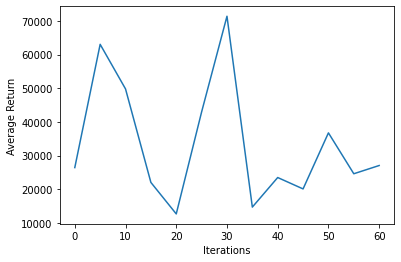

In [36]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [40]:
#run_simulation(eval_policy)
evaluatePolicy(eval_policy, eval_env)

0
0
[[12.7   36.6   16.    12.917 37.724 38.   ]]
84.40537156250002
0
0
[[ 5.8        26.2        16.         11.00998995 13.87603234 35.        ]]
66.9053715625
0
[[11.1        19.6        17.         18.54470137  1.42418869 33.        ]]
-45.107573437500065
0
0
0
0
[[16.5        36.8        13.         45.22411497 26.29247482 28.        ]]
62.96285656249995
[[ 8.6   34.    19.     9.268 48.75  27.   ]]
85.03533406249994
0
0
0
0
0
0
[[ 2.7        36.8         6.         47.82573768 43.29582754 20.        ]]
53.82257656249993
[[ 6.5        22.7         7.         36.60068231 21.46898496 19.        ]]
-38.41751843750002
[[12.1        20.7         8.         37.07006712 10.8048223  18.        ]]
-23.496250937500065
0
0
0
0
0
0
0
0
[[ 7.1        26.6        13.         15.17165801 19.54784937  9.        ]]
58.96285656249995
0
0
[[ 0.5        22.3        13.         19.68535935 11.76994105  6.        ]]
70.46285656249995
0
0
[[13.9   36.2   15.    25.166 20.345  3.   ]]
132.75344906249995


0
[[ 2.7        39.1        17.         10.26228664  4.6685373  21.        ]]
94.39242656249994
[[ 5.1        29.7        18.          6.84004198 29.88126941 20.        ]]
55.76868156249995
[[ 1.         42.4        18.         48.81097327 21.19676866 19.        ]]
139.76868156249998
[[ 3.9        39.6        20.         18.03621396  3.1602554  18.        ]]
197.93955906249994
0
0
[[11.1        23.5         8.         30.51562518 15.02749191 15.        ]]
-4.496250937500065
[[10.3        20.1        13.          5.5562228  14.14489714 14.        ]]
10.462856562499951
[[ 3.6        34.3        13.         19.22231697 46.71008388 13.        ]]
114.96285656249995
[[ 5.9        24.5        14.         21.88271736 24.59272322 12.        ]]
77.16627906249994
0
0
[[ 6.4        26.5        14.         27.54030929 39.66707017  9.        ]]
84.66627906249994
0
0
0
0
0
0
0
0
0
[[ 8.7   31.5   16.     3.956 41.626 -1.   ]]
78.90537156250002
0
0
0
[[ 3.4        29.         16.         26.74765097 1

0
0
[[ 8.7        22.3        16.         29.99141962  5.94857466 -1.        ]]
32.905371562499994
[[ 7.5        23.1        16.         45.71059818 10.88036813 -1.        ]]
42.905371562499994
[[ 5.6   31.3   17.    19.661 26.2   -1.   ]]
40.892426562499935
0
[[ 4.8        37.         18.         43.14830128 15.91413988 -1.        ]]
93.76868156249998
0
0
0
0
0
[[12.7        33.4        11.          9.5925178  29.98329841 -1.        ]]
209.12424156249998
0
[[ 3.4        19.8        11.         25.26505345 27.35923206 -1.        ]]
187.62424156249995
0
[[ 2.4        14.         12.         34.63295222  6.95028744 -1.        ]]
109.54505656249995
[[ 9.9        27.9        18.         48.24127534 19.16185792 -1.        ]]
22.76868156249995
driver reward  3834.5112615624994
0
0
0
0
0
0
[[ 1.3   20.3    9.    12.325 30.402 34.   ]]
160.45605656249995
0
0
0
0
0
0
[[ 4.7   33.1   17.     7.034  6.829 27.   ]]
54.39242656249991
0
0
0
[[ 6.2        24.7        20.         30.85242274 26.802082

[[21.7        29.7        17.          1.22633134 29.02826984 38.        ]]
-47.607573437500065
0
[[ 7.6        35.8        17.         42.3695951  23.37756173 36.        ]]
53.39242656249996
[[ 2.4        15.1        17.         43.86078512  9.78248773 35.        ]]
-24.107573437500065
0
[[10.    46.6   14.     9.124  9.808 33.   ]]
167.16627906249994
0
0
0
0
0
[[ 4.3        35.7        17.         39.37097304 49.06075154 27.        ]]
69.39242656249996
0
0
0
0
0
0
[[ 4.7   27.6   16.     6.639 41.356 20.   ]]
79.40537156249997
0
0
0
0
0
0
0
0
0
[[16.5        39.         19.         11.20824346  1.39647471 10.        ]]
70.53533406249994
0
0
0
0
[[12.         45.4        23.         41.11101767 58.67061798  5.        ]]
241.77545156249994
0
[[ 2.2        27.2         8.         28.05344783 16.27290961  3.        ]]
58.503749062499935
0
0
0
0
0
[[ 1.8        23.9        12.         21.61191222 32.71363768 -1.        ]]
162.04505656249995
0
[[ 7.         44.9        12.         37.71561

0
0
0
[[14.8        20.5        18.          2.24496845  5.94923387 -1.        ]]
-38.73131843750005
0
0
[[ 1.4        24.6        18.          3.13558135  2.19917957 -1.        ]]
48.76868156249995
[[ 3.3        18.6        18.         14.99436776 20.57706041 -1.        ]]
9.268681562499935
0
0
[[ 0.4        32.4        19.         18.73874928 54.23477417 -1.        ]]
118.03533406249994
[[14.2        24.6        19.          2.49977705 24.24532899 -1.        ]]
10.035334062499942
0
[[ 3.3        12.4        20.         12.3465449   9.99401782 -1.        ]]
64.93955906249994
0
0
0
0
0
0
0
[[ 9.2        27.3         8.         22.14712506 22.63837474 -1.        ]]
24.003749062499935
0
0
0
0
[[ 7.8        26.6        10.         31.88220346 44.57083432 -1.        ]]
209.53297906249998
0
[[ 5.1        20.2        12.         24.24414642 32.07535834 -1.        ]]
127.04505656249997
0
0
0
[[ 8.3        25.2        12.         28.32251678 26.10987131 -1.        ]]
136.04505656249995
0
[[ 8.

<ipython-input-29-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [52]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluateSavedPolicy(policy, policy_state, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf, policy_state)

            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)


In [19]:
#load saved policy
saved_policy = tf.compat.v2.saved_model.load('pol/policy_10')
policy_state = saved_policy.get_initial_state(batch_size=3)
"""time_step = ...
while True:
  policy_step = saved_policy.action(time_step, policy_state)
  policy_state = policy_step.state
  time_step = f(policy_step.action)
"""
observations = [8, 10, 0, 35]
#observation_ts = ts.transition(np.array(observations, dtype=np.float32), reward=0.0, discount=1.0)
observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]),
                                tf.convert_to_tensor(np.array([observations], dtype=np.float32), dtype=tf.float32))
action = saved_policy.action(observation_ts, policy_state)
print(action)

OSError: SavedModel file does not exist at: pol/policy_10/{saved_model.pbtxt|saved_model.pb}

In [ ]:
avg_return = compute_avg_return(saved_policy, num_eval_episodes)

In [ ]:
#evaluateSavedPolicy(saved_policy, policy_state, eval_env)
evaluatePolicy(eval_policy, eval_env)

In [ ]:
"""


reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""

##############################################################################################



In [ ]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [ ]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [3]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""

"\ntime_step = tf_env.reset()\nrewards = []\nsteps = []\nnum_episodes = 5\n\nfor _ in range(num_episodes):\n  episode_reward = 0\n  episode_steps = 0\n  while not time_step.is_last():\n    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)\n    time_step = tf_env.step(action)\n    episode_steps += 1\n    episode_reward += time_step.reward.numpy()\n  rewards.append(episode_reward)\n  steps.append(episode_steps)\n  time_step = tf_env.reset()\n\nnum_steps = np.sum(steps)\navg_length = np.mean(steps)\navg_reward = np.mean(rewards)\n\nprint('num_episodes:', num_episodes, 'num_steps:', num_steps)\nprint('avg_length', avg_length, 'avg_reward:', avg_reward)\n"